# **Watch Reviews Analysis**

# Part 0: Setup Environment and Load Data

In [ ]:
import numpy as np
import pandas as pd

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# https://drive.google.com/file/d/1O6lhXvz0AthavxElCZDlFIocZXc0oMT6/view?usp=drive_link
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = "1O6lhXvz0AthavxElCZDlFIocZXc0oMT6"

file = drive.CreateFile({'id':id})
file.GetContentFile('watch_reviews.tsv')

df = pd.read_csv('watch_reviews.tsv', sep='\t', on_bad_lines = 'skip')
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960204 non-null  object
 1   customer_id        960204 non-null  int64 
 2   review_id          960204 non-null  object
 3   product_id         960204 non-null  object
 4   product_parent     960204 non-null  int64 
 5   product_title      960202 non-null  object
 6   product_category   960204 non-null  object
 7   star_rating        960204 non-null  int64 
 8   helpful_votes      960204 non-null  int64 
 9   total_votes        960204 non-null  int64 
 10  vine               960204 non-null  object
 11  verified_purchase  960204 non-null  object
 12  review_headline    960191 non-null  object
 13  review_body        960045 non-null  object
 14  review_date        960200 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [ ]:
df.dropna(subset=['review_body'],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 960045 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960045 non-null  object
 1   customer_id        960045 non-null  int64 
 2   review_id          960045 non-null  object
 3   product_id         960045 non-null  object
 4   product_parent     960045 non-null  int64 
 5   product_title      960043 non-null  object
 6   product_category   960045 non-null  object
 7   star_rating        960045 non-null  int64 
 8   helpful_votes      960045 non-null  int64 
 9   total_votes        960045 non-null  int64 
 10  vine               960045 non-null  object
 11  verified_purchase  960045 non-null  object
 12  review_headline    960032 non-null  object
 13  review_body        960045 non-null  object
 14  review_date        960041 non-null  object
dtypes: int64(5), object(10)
memory usage: 117.2+ MB


In [ ]:
reviews1000 = df.loc[:1000, 'review_body'].tolist()
reviews1000[:5]

['Absolutely love this watch! Get compliments almost every time I wear it. Dainty.',
 'I love this watch it keeps time wonderfully.',
 'Scratches',
 'It works well on me. However, I found cheaper prices in other places after making the purchase',
 "Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch"]

# Part 1: Tokenization and Stemming

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br")
stopwords.append("watch")

In [ ]:
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = []
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())
    filtered_tokens = []
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [ ]:
reviews1000[0]

'Absolutely love this watch! Get compliments almost every time I wear it. Dainty.'

In [ ]:
tokenized_docs1000 = tokenization_and_stemming(reviews1000[0])
tokenized_docs1000

['absolut',
 'love',
 'get',
 'compliment',
 'almost',
 'everi',
 'time',
 'wear',
 'dainti']

# Part 2: TF-IDF

In [ ]:
tfidf_model = TfidfVectorizer(max_df = 0.99, max_features=1000,
                              min_df = 0.01, stop_words='english',
                              tokenizer = tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(reviews1000)
tfidf_matrix

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  war

<1000x239 sparse matrix of type '<class 'numpy.float64'>'
	with 6891 stored elements in Compressed Sparse Row format>

In [ ]:
print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 1000 reviews and 239 terms.


In [ ]:
tfidf_matrix.toarray()

array([[0.       , 0.5125863, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [ ]:
tfidf_selected_words = tfidf_model.get_feature_names_out()
tfidf_selected_words

array(['abl', 'absolut', 'accur', 'actual', 'adjust', 'alarm', 'alreadi',
       'alway', 'amaz', 'amazon', 'anoth', 'arm', 'arriv', 'automat',
       'awesom', 'bad', 'band', 'batteri', 'beauti', 'best', 'better',
       'big', 'bit', 'black', 'blue', 'bought', 'box', 'bracelet',
       'brand', 'break', 'bright', 'broke', 'button', 'buy', 'ca', 'came',
       'case', 'casio', 'chang', 'cheap', 'clasp', 'classi', 'clock',
       'color', 'come', 'comfort', 'compliment', 'cool', 'cost', 'crown',
       'crystal', 'dark', 'date', 'daughter', 'day', 'deal', 'definit',
       'deliveri', 'design', 'dial', 'differ', 'difficult', 'disappoint',
       'display', 'dress', 'durabl', 'easi', 'easili', 'end', 'everi',
       'everyday', 'everyth', 'exact', 'excel', 'expect', 'expens',
       'face', 'fair', 'far', 'fast', 'featur', 'feel', 'fell', 'fine',
       'finish', 'fit', 'function', 'gave', 'gift', 'gold', 'good', 'got',
       'great', 'hand', 'happi', 'hard', 'heavi', 'high', 'hold',
 

# Part 3: K-means Clustering

In [ ]:
num_clusters = 5
km = KMeans(n_clusters = num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
product = {'review': df[:1000].review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])
frame.head()

,review,cluster
0,Absolutely love this watch! Get compliments al...,3
1,I love this watch it keeps time wonderfully.,3
2,Scratches,0
3,"It works well on me. However, I found cheaper ...",0
4,Beautiful watch face. The band looks nice all...,0


In [ ]:
frame['cluster'].value_counts()

cluster
0    655
3    111
1     97
2     75
4     62
Name: count, dtype: int64

In [ ]:
km.cluster_centers_

array([[0.00576005, 0.00505063, 0.00389886, ..., 0.00665073, 0.01776423,
        0.01346962],
       [0.00332465, 0.        , 0.        , ..., 0.00229765, 0.00388971,
        0.02402288],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00874405,
        0.        ],
       [0.        , 0.03772615, 0.        , ..., 0.01222159, 0.01717547,
        0.00400254],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00784247,
        0.        ]])

In [ ]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]:
        Cluster_keywords_summary[i].append(tfidf_selected_words[ind])
        print (tfidf_selected_words[ind] + ",", end='')

    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
    print (", ".join(cluster_reviews))
    print ()

Cluster 0 words:like,look,work,band,time,beauti,
Cluster 0 reviews (655 reviews): 
Scratches, It works well on me. However, I found cheaper prices in other places after making the purchase, Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch, I was about to buy this thinking it was a Swiss Army Infantry watch-- the description uses the words infantry and army--- when I realized it must be a fraud for $12.00. This should not be offered on Amazon-- it is designed to confuse consumer

**Insights:**

* Cluster 0: overall good reviews;
* Cluster 1: words such as "wife, husband, wife" may indicate people bought this watch as gifts;
* Cluster 2: overall good reviews;
* Cluster 3: words such as "good, qualiti, price" may indicate the quality of this watch is approved by customers;
* Cluster 4: similar with cluster 4, word like "price" may indicate the good quality.


Words overlapped with each other among clusters, but overall, we can infer that customers are willing to buy this watch as a gift to the love. Also, this watch is in good quality and price.



# Part 4: Topic Modeling: Latent Dirichlet Allocation

In [ ]:
lda = LatentDirichletAllocation(n_components = 5)
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output)

[[0.05938495 0.33773237 0.05959139 0.48331665 0.05997463]
 [0.08425711 0.66304847 0.0830493  0.08575167 0.08389345]
 [0.2        0.2        0.2        0.2        0.2       ]
 ...
 [0.10000034 0.10000039 0.10033169 0.10005101 0.59961657]
 [0.73102174 0.06693472 0.06714558 0.06728789 0.06761008]
 [0.06820419 0.06760415 0.06723528 0.72865644 0.06829995]]


In [ ]:
topic_word = lda.components_
print(topic_word)

[[0.20088173 0.20008134 0.20094485 ... 0.20089601 3.84043457 0.28811383]
 [1.99942119 7.38756839 0.20035496 ... 0.20058939 1.07370559 0.20352781]
 [0.2058448  0.20146959 0.20786473 ... 0.20121168 0.2019188  0.64196035]
 [2.12781022 0.47881666 2.74327335 ... 6.13234456 4.19990776 9.07923883]
 [0.56136913 0.22782684 0.2013172  ... 0.20065566 6.74542108 2.38426463]]


In [ ]:
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]
doc_names = ["Doc" + str(i) for i in range(len(reviews1000))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic
df_document_topic.head(5)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.06,0.34,0.06,0.48,0.06,3
Doc1,0.08,0.66,0.08,0.09,0.08,1
Doc2,0.20,0.20,0.20,0.20,0.20,0
Doc3,0.06,0.06,0.06,0.76,0.06,3
Doc4,0.04,0.04,0.40,0.47,0.04,3


In [ ]:
df_document_topic['topic'].value_counts()

topic
3    330
0    197
4    197
2    144
1    132
Name: count, dtype: int64

In [ ]:
df_topic_words = pd.DataFrame(lda.components_)
df_topic_words.columns = tfidf_model.get_feature_names_out()
df_topic_words.index = topic_names
df_topic_words.head()

,abl,absolut,accur,actual,adjust,alarm,alreadi,alway,amaz,amazon,...,weight,went,wife,wind,wish,work,worn,worth,wrist,year
Topic0,0.200882,0.200081,0.200945,1.445416,0.201723,0.200269,1.057238,0.203460,0.200124,0.200865,...,0.200519,0.200353,0.201979,0.694329,0.200062,0.202923,0.200113,0.200896,3.840435,0.288114
Topic1,1.999421,7.387568,0.200355,0.979980,0.204119,0.735973,2.240788,0.200259,0.200908,2.443190,...,0.201232,0.200624,0.201157,0.200844,0.542418,0.211939,0.201845,0.200589,1.073706,0.203528
Topic2,0.205845,0.201470,0.207865,0.823987,1.533553,0.200283,0.202676,0.205917,0.201334,0.207374,...,0.607614,0.205425,0.200658,0.200050,0.200146,28.880400,0.202387,0.201212,0.201919,0.641960
Topic3,2.127810,0.478817,2.743273,2.010916,0.219580,4.602865,2.060939,4.029534,0.202347,3.750012,...,0.207408,2.908859,11.837187,2.938102,2.564752,11.210865,0.219893,6.132345,4.199908,9.079239
Topic4,0.561369,0.227827,0.201317,0.596098,4.134196,0.201021,0.201728,0.200832,9.964122,0.201099,...,4.501590,0.201913,0.201417,0.200384,1.063131,0.555540,3.378855,0.200656,6.745421,2.384265


In [ ]:
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names_out())
    topic_words = []
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,nice,great,look,price,band,expect,recommend,pictur,cool,leather,super,simpl,size,time,exact
Topic 1,love,excel,beauti,awesom,fast,pleas,thank,husband,absolut,invicta,pretti,deliveri,ship,price,time
Topic 2,work,like,product,band,broke,week,feel,day,cheap,got,batteri,good,replac,look,metal
Topic 3,love,time,look,color,want,realli,great,like,gift,wear,wife,watch,use,month,bought
Topic 4,good,perfect,littl,comfort,amaz,big,fit,look,far,great,wear,price,deal,qualiti,light


**Insights:**

* Topic 0: word 'bad' needs attention, but overall good reviews;
* Topic 1: word 'band' and 'great, ... , comfort' may indicate that customers are satisfied with watch band;
* Topic 2: word 'price' and other compliment words may indicate customers are satisfied with the price; word 'wife' may indicate this watch is considered as a gift to the love by some customers; words 'ship, fast' may indicate custoemrs are satisfied with the shipment;
* Topic 3: word 'return' may indicate customers are satisfied with the return process;
* Topic 4: words 'gift' may indicate customers buy it as a gift to their loves; words "broke, worth" need attention, which may refer to color, band, or batteri of the watch.  


There may be some negative reviews about the color, band, or battey of the watch. Also, shipment and return methods are mentioned, but we are not sure whether customers are satisfied or dissatisfied with shipment and return. In addition, customers buy this watch as a gift to the love.



# Part 5: Evaluation

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(lda_output)

In [ ]:
df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_pca['Topic'] = np.argmax(lda_output, axis=1)
df_pca.head()

,PCA1,PCA2,Topic
0,0.234895,-0.060236,3
1,-0.193912,-0.134769,1
2,-0.092634,-0.030845,0
3,0.525091,0.001263,3
4,0.230895,-0.099164,3


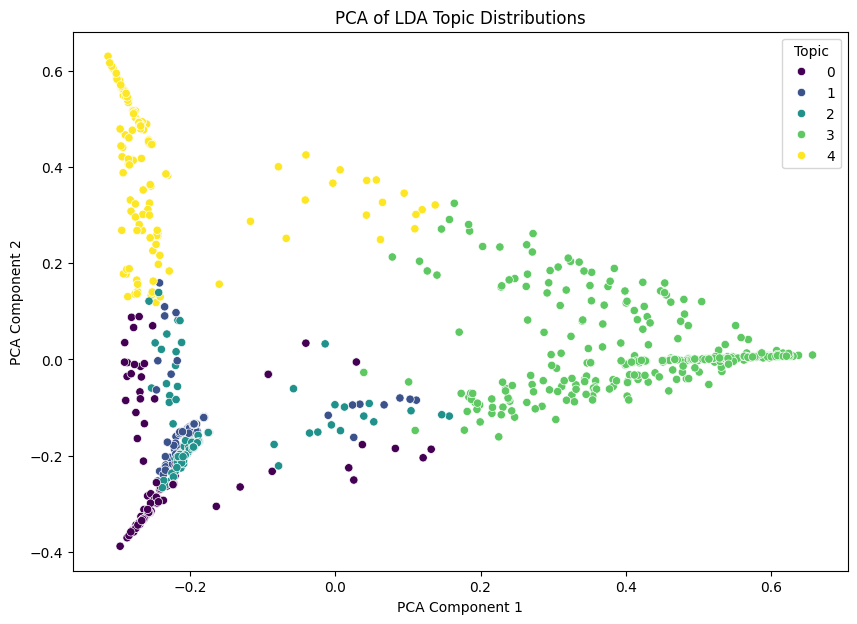

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Topic', data=df_pca, palette='viridis')
plt.title('PCA of LDA Topic Distributions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Topic')
plt.show()

**Insights:**

* The distinct clusters of Topics 3 and 4 imply that the LDA model has successfully identified strong, coherent topics for these clusters.
* The overlapping clusters of Topics 0, 1, and 2 might indicate the need for further refinement. This could involve adjusting the number of topics, tuning hyperparameters, or preprocessing the text data more effectively.



# Part 6: Summary

With the use of k-means clustering and LDA, we get some useful information from customer reviews which can be used for problem identification, product improvement, and product promotion in order to boost sales.


*   Watch as a gift: we can promote this watch to those customers in Valentine's Day, birthday, or other related important days;
*   Ship and return: we can explore in depth to find more detailed customer experiences;
*   Quality: as there are oppposite reviews in one or more aspects of the watch, such as band, style, color, battery, we can start from these key words to see individual case so that we can figure it out whether the case is an accidental event or there is indeed quality problem.

